In [31]:
import os
import numpy as np
import zipfile
from ultralytics import YOLO
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import cv2 as cv
import pandas as pd
import matplotlib.pyplot as plt

In [32]:
# if it is unzipped, unzip kagglecatsanddogs_5340.zip
if not os.path.exists('PetImages') and not os.path.exists('images'):
    # unzip kagglecatsanddogs_5340.zip
    print("The file is not unzipped, unzipping it now")
    with zipfile.ZipFile("kagglecatsanddogs_5340.zip","r") as zip_ref:
        zip_ref.extractall()
    # delete unnecessary files
    os.remove("CDLA-Permissive-2.0.pdf")
    os.remove("readme[1].txt")
else:
    print("The file is already unzipped")

The file is already unzipped


In [33]:
# rename the images as img_0.jpg, img_1.jpg, etc. and save the labels in a pandas dataframe where 0 is cat and 1 is dog
# there is ID and label in the dataframe
# the labels are 0 for cat and 1 for dog
# images folder should be in the same directory as this file

if not os.path.exists('images'):
    print("Creating images folder and labels dataframe")
    os.makedirs('images')
    os.makedirs('other_images')
    os.makedirs('val_images')
    other_images_split = 0.1
    val_images_split = 0.1
    other_images_count = 0
    labels = pd.DataFrame(columns=['ID', 'label'])
    val_labels = pd.DataFrame(columns=['ID', 'label'])
    count = 0
    corrupted_count = 0
    val_count = 0
    for folder in ['Cat', 'Dog']:
        for i, file in enumerate(os.listdir('PetImages/'+folder)):
            # choose randomly with other_images_split percent of the images to be in the other_images folder
            if np.random.rand() < other_images_split:
                try:
                    img_array = cv.imread('PetImages/'+folder+'/'+file)
                    otherImage = cv.resize(img_array, (256, 256), interpolation=cv.INTER_AREA)
                    os.rename('PetImages/'+folder+'/'+file, 'other_images/img_'+str(other_images_count)+'.jpg')
                    other_images_count += 1
                except Exception as e:
                    corrupted_count += 1
                    print(e)
                    print('Deleting ', 'PetImages/'+folder+'/'+file)
                    os.remove('PetImages/'+folder+'/'+file)
            elif np.random.rand() < val_images_split:
                try:
                    img_array = cv.imread('PetImages/'+folder+'/'+file)
                    otherImage = cv.resize(img_array, (256, 256), interpolation=cv.INTER_AREA)
                    os.rename('PetImages/'+folder+'/'+file, 'val_images/img_'+str(val_count)+'.jpg')
                    val_labels.loc[val_count] = [val_count, 0 if folder == 'Cat' else 1]
                    val_count += 1
                except Exception as e:
                    corrupted_count += 1
                    print(e)
                    print('Deleting ', 'PetImages/'+folder+'/'+file)
                    os.remove('PetImages/'+folder+'/'+file)
            else:
                try:
                    img_array = cv.imread('PetImages/'+folder+'/'+file)
                    otherImage = cv.resize(img_array, (256, 256), interpolation=cv.INTER_AREA)
                    os.rename('PetImages/'+folder+'/'+file, 'images/img_'+str(count)+'.jpg')
                    labels.loc[count] = [count, 0 if folder == 'Cat' else 1]
                    count += 1
                except Exception as e:
                    corrupted_count += 1
                    print(e)
                    print('Deleting ', 'PetImages/'+folder+'/'+file)
                    os.remove('PetImages/'+folder+'/'+file)
    # delete the PetImages folder
    if os.path.exists('PetImages'):
        if os.path.exists('PetImages/Cat'):
            os.rmdir('PetImages/Cat')
        if os.path.exists('PetImages/Dog'):
            os.rmdir('PetImages/Dog')
        os.rmdir('PetImages')
    #  save the labels dataframe as a csv file
    labels.to_csv('labels.csv')
    val_labels.to_csv('val_labels.csv')
    print("Number of corrupted images: ", corrupted_count)
else:
    print("images folder already exists")

        

images folder already exists


In [34]:
#defining dataset class
class Dataset(torch.utils.data.Dataset):
      'Characterizes a dataset for PyTorch'
      def __init__(self, image_dir, label_dir, transform=None):
            'Initialization'
            self.image_dir = image_dir
            self.label_dir = label_dir
            self.transform = transform

            self.labels = pd.read_csv(label_dir)
            self.images = []
            # go through the images folder and add the names of the images to the images list with the order
            for i, file in enumerate(os.listdir(image_dir)):
                  self.images.append(f"img_{str(i)}.jpg")
            # Note: store the directory of the images instead of the images themselves


      def __len__(self):
            # return the number of samples
            return len(self.labels)

      def __getitem__(self, index):
            'Generates one sample of data'
            img_dir = self.images[index]
            img = cv.imread(self.image_dir + '/' + img_dir)
            if self.transform:
                  img = self.transform(img)
            label = self.labels.loc[self.labels['ID'] == index, 'label'].item()
            return img, label



In [43]:
# create the train dataset and dataloader

# define the transformation where the the image is read from the directory, resized to 256x256, normalized and converted to a tensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5,0.5,0.5])
])

train_dataset = Dataset(image_dir='images', label_dir='labels.csv', transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=5, shuffle=True)

val_dataset = Dataset(image_dir='val_images', label_dir='val_labels.csv', transform=transform)

val_dataloader = DataLoader(val_dataset, batch_size=5, shuffle=True)

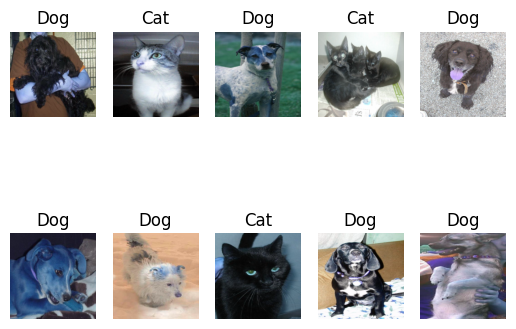

In [53]:
## test the train and val dataloader

# get a batch of images and labels and plot the images and show their labels
# test the train dataloader
train_images, train_labels = next(iter(train_dataloader))

# test the validation dataloader
val_images, val_labels = next(iter(val_dataloader))

# plot a batch of train and val images with their labels. First row is train and second row is val
fig, ax = plt.subplots(2, 5)
for i in range(5):
    train_img = train_images[i].permute(1, 2, 0)
    train_img = train_img * 0.5 + 0.5    # un normalize the image
    ax[0, i].imshow(train_img)
    ax[0, i].set_title("Cat" if train_labels[i] == 0 else "Dog")
    ax[0, i].axis('off')
    val_img = val_images[i].permute(1, 2, 0)
    val_img = val_img * 0.5 + 0.5    # un normalize the image
    ax[1, i].imshow(val_img)
    ax[1, i].set_title("Cat" if val_labels[i] == 0 else "Dog")
    ax[1, i].axis('off')
plt.show()

In [55]:
# define the model
# we are using AlexNet model with 2 classes
# we are defining the model from scratch

class AlexNet(torch.nn.Module):
    def __init__(self, num_classes=2, dropout_prob=0.5):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(dropout_prob),
            nn.Linear(9216, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(dropout_prob),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        # define the forward pass
        z = self.layer1(x)
        z = self.layer2(z)
        z = self.layer3(z)
        z = self.layer4(z) 
        z = self.layer5(z)
        z = z.reshape(z.size(0), -1)
        z = self.fc(z)
        z = self.fc1(z)
        z = self.fc2(z)
        return z
        

In [56]:
# try the forward pass using the train dataloader

myModel = AlexNet()

images, labels = next(iter(train_dataloader))

result1 = myModel.forward(images)

print(result1)
print(result1.shape)

tensor([[ 0.0864, -0.2948],
        [-0.1603,  0.0818],
        [-0.3119, -0.1445],
        [ 0.4121,  0.2518],
        [-0.0711,  0.1389]], grad_fn=<AddmmBackward0>)
torch.Size([5, 2])


c:\Users\NSagi\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [57]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Current device:', device)

if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Current device: cuda
GPU Name: NVIDIA GeForce GTX 1650 with Max-Q Design
Total GPU Memory: 4.0 GB


In [58]:
## Define hyperparameters
leanring_rate = 0.001
epochs = 10
dropout_prob = 0.5
num_classes = 2

In [59]:
## define the loss function and optimizer

# define the loss function
loss_function = nn.CrossEntropyLoss()

# define the optimizer
optimizer = torch.optim.Adam(myModel.parameters(), lr=0.001)

In [ ]:
## train the model
# TODO